In [0]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import os
import struct
import numpy as np
import h5py
import cv2

In [2]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
device = get_default_device()
print(device)

def to_device(data,device):
    if isinstance(data, (list,tuple)):
        return [to_device(x,device) for x in data]
    else:
        return data.to(device, non_blocking=True)
    
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

cuda


In [151]:
def loadMNIST(dataset="train", path=""):

    fname_img = os.path.join('t10k-images-idx3-ubyte')
    fname_lbl = os.path.join('t10k-labels-idx1-ubyte')

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows * cols)

    new_img = np.zeros((10000,16,16))
    for i in range(10000):
        tmp = np.reshape(img[i],(28,-1))
        tmp = cv2.resize(tmp, dsize=(16,16), interpolation=cv2.INTER_AREA)
        new_img[i] = tmp

    lbl = lbl.astype(int)
    X_te, y_te = new_img[7291:2007+7291], lbl[7291:2007+7291]
    X_tr, y_tr = new_img[:7291], lbl[:7291]
    
    if dataset=="train":
        print("MNIST training size: ", X_tr.shape,"  | labels: ", y_tr.shape)
        return X_tr, y_tr
    else:
        print("MNIST testing size: ", X_te.shape,"  | labels: ", y_te.shape)
        return X_te, y_te

training size:  (7291, 16, 16)   | labels:  (7291,)


In [152]:
def loadUSPS(dataset="train"):
    with h5py.File("usps.h5", 'r') as hf:
        train = hf.get('train')
        X_tr = train.get('data')[:].reshape(-1,16,16)
        y_tr = train.get('target')[:]
        test = hf.get('test')
        X_te = test.get('data')[:].reshape(-1,16,16)
        y_te = test.get('target')[:]
    
    
    if dataset=="train":
        print("USPS training size: ", X_tr.shape,"  | labels: ", y_tr.shape)
        return X_tr,y_tr
    else:
        print("USPS testing size: ", X_te.shape,"  | labels: ", y_te.shape)
        return X_te,y_te

training size:  (7291, 16, 16)   | labels:  (7291,)


In [0]:
def imshow(img,text=None,should_save=False):
    npimg = img#.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

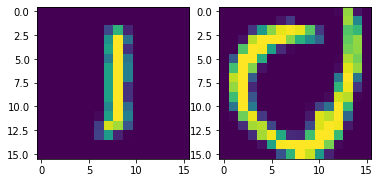

In [154]:
i = 14
fig,ax = plt.subplots(1,2)
ax[0].imshow(mdata[i])
ax[1].imshow(udata[i])

In [0]:
class Config():
    train_batch_size = 64
    train_number_epochs = 100
Config = Config()

In [0]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,dataset="train",transform=None, data_size=10000):
        self.transform = transform
        self.X1, self.y1 = loadMNIST(dataset)
        self.X2, self.y2 = loadUSPS(dataset)
        self.data_size = data_size
        
    def __getitem__(self,index):
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            if(random.randint(0,1)==0):
                img0_tuple = random.choice(self.X1)
                img1_tuple = random.choice(self.X1) #self.X1[index]#
            else:
                img0_tuple = random.choice(self.X2)
                img1_tuple = random.choice(self.X2)#self.X2[index]
        else:
            img0_tuple = random.choice(self.X1)#self.X1[index]
            img1_tuple = random.choice(self.X2)#self.X2[index]

        img0 = Image.fromarray(img0_tuple)
        img1 = Image.fromarray(img1_tuple)

        img0 = self.transform(img0)
        img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array(1-should_get_same_class,dtype=np.float32))
    
    def __len__(self):
        return self.data_size 

In [0]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0], [0.5])
])

In [207]:
train_dataset = SiameseNetworkDataset(dataset="train",transform=data_transform)
Config.train_batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=Config.train_batch_size, shuffle=True, num_workers=4)
train_loader = DeviceDataLoader(train_loader, device)

training size:  (7291, 16, 16)   | labels:  (7291,)
training size:  (7291, 16, 16)   | labels:  (7291,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


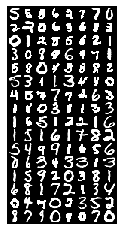

[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0.]


In [208]:
dataiter = iter(train_loader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated.cpu()))
print(example_batch[2].cpu().numpy())

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            # nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            # nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            # nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*10*10, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [0]:
 class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [0]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss(margin=5)
optimizer = optim.Adam(net.parameters(),lr = 0.001)


In [0]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch: 0 |  Loss: 1517.7854113578796
Epoch: 10 |  Loss: 1454.662610054016
Epoch: 20 |  Loss: 1446.8793182373047
Epoch: 30 |  Loss: 1445.178994178772
Epoch: 40 |  Loss: 1446.4125652313232
Epoch: 50 |  Loss: 1447.6307334899902
Epoch: 60 |  Loss: 1448.1715650558472
Epoch: 70 |  Loss: 1444.0107026100159
Epoch: 80 |  Loss: 1446.0104894638062
Epoch: 90 |  Loss: 1447.9779863357544


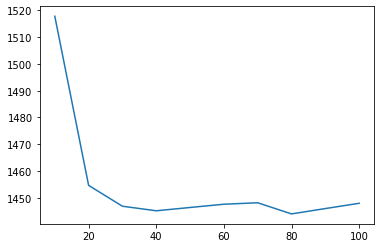

In [213]:
Config.train_number_epochs = 100
for epoch in range(0,Config.train_number_epochs):
    total_loss = 0
    for i, data in enumerate(train_loader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        total_loss += loss_contrastive.item()
        optimizer.step()
    if epoch%10==0:
        print("Epoch: {} |  Loss: {}".format(epoch,total_loss))
        iteration_number +=10
        counter.append(iteration_number)
        loss_history.append(total_loss)
show_plot(counter,loss_history)

In [220]:
test_dataset = SiameseNetworkDataset(dataset="test",transform=data_transform, data_size=1000)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True, num_workers=4)
test_loader = DeviceDataLoader(test_loader, device)

testing size:  (2007, 16, 16)   | labels:  (2007,)
testing size:  (2007, 16, 16)   | labels:  (2007,)


In [229]:
l_same, l_diff = 0,0
c_same,c_diff = 0,0
error = 0
threshold = 1.1
for _, data in enumerate(test_loader,0):
    x0,x1,label2 = data
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    if not label2:
        c_same += 1
        l_same += euclidean_distance.item()
        if euclidean_distance.item()>=threshold:
            error += 1
    else:
        c_diff += 1
        l_diff += euclidean_distance.item()
        if euclidean_distance.item()<threshold:
            error += 1

    '''
        uncomment the 4 lines below to see the inputs and the dissimilarity score!
    '''
    # imshow(torchvision.utils.make_grid(concatenated.cpu()),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
    # print(label2)
    # if _==10:
    #   break
print("avg loss for same domain : ", l_same/c_same," |  diff domain : ",l_diff/c_diff)
print("num of same : ", c_same, "  | diff : ", c_diff)
print("error: ", error/(c_same+c_diff))

avg loss for same domain :  0.7262504922277607  |  diff domain :  2.4413444337091947
num of same :  506   | diff :  494
error:  0.121
